# ASTR3110 Computer Laboratory 1: The Period-Luminosity relation using Cepheid variable stars from Gaia (Week 3, 4, 5).

In this lab, you will use data from the Gaia Data Release 3 (Gaia DR3; also including Gaia Early Data Release 3) to calibrate the Type I Cepheid period-luminosity relation, also known as the "Leavitt's law" honouring Henrietta Swan Leavitt who first discovered the relation using Cepheids in the Large Magellanic Cloud. We discussed the Period-Luminosity relation for Type I Cepheids in the Week 2 lectures.

In the first part of the lab, you will hone your data massaging skills using Pandas to weed out bad data in order to select a high-fidelity sample of Type I Cepheids (also known as Delta Cepheids or Classical Cepheids) ready for calibrating the Leavitt law. You will determine which of the parameters are required for measuring Leavitt's law, and also calculate the required new quantities and associated uncertainties. 

In the second part of the lab, you will use your knowledge of fitting data to determine the best-fitting straight-line parameterisation of Leavitt's Law. You will use two methods to do this: standard optimisation and MCMC. You will compare the results from the two methods, and also compare the results of the two different measurements of distance derived from the Gaia parallax measurements. 

In the third part of the lab, you will use your calibrated Leavitt Law to determine the distance to the Large Magellanic Cloud.

<font color='red'> **Checkpoints for where you should aim to be up to at the end of each lab are highlighted in red throughout the notebook.**</font>

At the completion of this lab, you will have acquired (or improved) the following skills:
- Data filtering using Pandas.
- Manipulating data to derive required parameters.
- Plotting data and interpreting plots.
- Fitting models to data using standard optimisation and MCMC.

You will be required to submit **two separate files** via iLearn (see the lab submission portal in the Assessments tab) by 11:55pm Monday 1st April 2024. The files are:

1. **Your Colab notebook containing your code.** We will randomly select code cells to inspect and will mark them based on the following criteria, each worth **10 marks**:
    - **Comments: Your code must be commented and your comments should demonstrate that you understand what your code is doing, and why! You can insert comments by either adding explanation text placed in blocks just before code blocks OR as comments within the code blocks themselves. The marking rubric is as follows:**

            8.5-10: Thorough comments that clearly explain what and why, demonstrating excellent understanding of code.
            7.5-8.5: Comments that explain what and mostly why, demonstrate good understanding.
            6.5-7.5: Comments that mostly explain what, not why, mostly demonstrate understanding.
            5.0-6.5: Some comments explaining what or why, some demonstration of understanding.
            < 5.0: Minimal comments.

    - **Formatting of your code. Rubric:**

            8.5-10: Code is clear and easy to understand with sensible variable names.
            7.5-8.5: Mostly clear, understandable with semi-sensible variable names.
            6.5-7.5: Code is understandable OR good variable names.
            5-6.5: Some effort in formatting code OR using sensible variable names.
            < 5.: Spaghetti code, remnants of code bits that failed to run.

2. **A document (preferrably in pdf format) that contains the plots, answers to questions, and explanation requests <font color='blue'>highlighted in blue throughout the notebbook.</font>** We will mark those based on the following criteria, again worth **10 marks** each:
    - **Plots: Your plots should be well presented and explained. Rubric:**

            8.5-10: All requested plots are included and are accompanied by a caption that thoroughly explains them and details what they show and why plotted. Plots have clear symbols, clearly labeled axes, and axis ranges are set so that trends visible.
            7.5-8.5: All requested plots included and accompanied by captions that mostly explain what and why. Plots include good labels, ranges, and symbols.
            6.5-7.5: Most requested plots are included and captions mostly explain what. Good labels, ranges, and symbols. 
            5-6.5: Most requested plots included, captions contain some explanation. Adequate labels, ranges, and symbols.
            < 5.0: Many missing plots, minimal effort in explaining or making sure plots/labels are clear.

    - **Comments and answers to any questions posed in the notebooks as well as comments on interpretation/comparison of results. Rubric:**

            8.5-10: Correct, detailed answers and comments for all questions and comparisons/interpretation.
            7.5-8.5: Correct answers and comments for most questions and comparisons/interpretations.
            6.5-7.5: Correct answers and comments for subset of questions and comparisons/interpretations.
            5-6.5: Some effort at answering questions and/or comparing/interpreting results.
            <5: No/minimal effort.

    - **Thorough explanations and justification for filtering of the data. Rubric:**

            8.5-10: Complete, thorough explanation and justification of how and why filtering was performed on the data. Demonstrates thorough understanding.
            7.5-8.5: Complete description of data filtering that mostly includes explanation AND justification.
            6.5-7.5: Filtering mostly explained OR justified.
            5-6.5: Some effort at one of explaining or jusitifying.
            <5: No/minimal effort at explaining or justifying data filtering.


# Part 1: Obtaining the data and applying basic filters

In this part, we will retrieve the Gaia data from the archive, and weed out obviously bad data.
## 1.1 Downloading the data

The data for this practical comes from the [Gaia](https://www.cosmos.esa.int/web/gaia/) mission and must be downloaded from the online Gaia archive at [http://gea.esac.esa.int/archive/](http://gea.esac.esa.int/archive/). The tabular data is retrieved from the database via an astronomy data query language (ADQL) statement:

```
SELECT source_id, dist.r_med_geo, dist.r_lo_geo, dist.r_hi_geo, dist.flag, src.ra, src.dec, src.L, src.B, src.parallax, src.parallax_error, cep.type_best_classification, cep.mode_best_classification, cep.pf, cep.pf_error, cep.int_average_bp, cep.int_average_bp_error, cep.int_average_g, cep.int_average_g_error, cep.int_average_rp, cep.int_average_rp_error, cep.num_clean_epochs_g
FROM external.gaiaedr3_distance as dist 
JOIN gaiadr3.vari_cepheid AS cep USING (source_id) 
JOIN gaiadr3.gaia_source AS src USING (source_id)
```

This query selects multiple columns from 3 tables in the archive that are merged using a common ```source_id``` column. We will describe what data each of the columns contains later in this notebook. 

At the Gaia archive page linked above, go to Search -> Advanced (ADQL) and copy the query into the box. Run the query and when finished save locally using the download icon on the right in the job window. Once you have the file on your local disk, you will need to upload to your google drive in order to allow Colab to access the data. Save the file to the same working directory that your Lab 1 python notebook is stored in. Note that the downloaded file compressed as a 'GZIP' archive. 

In the cell below, import your google drive so that Colab can access the data there (see instructions at [link](https://github.com/MQ-ASTR3110/ASTR3110_Tutorial_Notebooks_2024/blob/master/SETUP_COLAB.md)). Change to the directory that the Gaia data are saved under, and unzip the file using the command ```!gunzip filename.gz``` in a cell. Double check to make sure all has gone to plan (e.g., run the !ls command to list the files in your current directory).

## 1.2 Inspecting the data 

The tabular data is in an XML-like format called 'VOTable', where VO stands for 'virtual observatory'. Dedicated software like [TOPCAT](http://www.star.bris.ac.uk/~mbt/topcat/) can be used to view, manipulate and plot the data. However, for our analysis we will convert the table to a [Pandas](https://pandas.pydata.org/) dataframe. As you will recall from the second lectorial, Pandas is a high-performance module for doing data analysis with Python and is used widely outside of astronomy.

In [ ]:
# Start by importing necessary Python modules
from astropy.io.votable import parse
import pandas as pd
import numpy as np

In [ ]:
# Define a function to read a VOTable and return a DataFrame
def votable_to_pandas(voTabFileName, indx=0):
    """
    Reads a VOTable file and returns a Pandas dataframe.
    Reads only one sub-table, specified by the indx argument.
    """
    
    # Parse the VOTable into a table tree & convert 1st sub-table to an AstroPy table
    voTabTree = parse(voTabFileName)
    apTab = voTabTree.get_table_by_index(indx).to_table(use_names_over_ids=True)
    
    return apTab.to_pandas()

Now we run our conversion function on the VOTable to read the table into memory. The converter may issue a few warnings, but these can be safely ignored. In the cell below, use the function defined above to read your VOTable into a Pandas DataFrame.

We can inspect the format of the table using the ```head()``` method of the dataframe ('methods' are functions that live inside python 'objects', like tables, and operate only on the parent object). In the cell below, print the first 10 rows.

Note that the leftmost column above displays the row-index of the table. This can be an integer (as above) or a text field. We can see that there are a large number of columns, so the ```head()``` method does not display them all. We can print all the column names like this "gaiaDF.columns". In the cell below, write a for loop that loops through the columns and prints the column number and name.

The meanings of the column names can be found in the [GAIA data model documentation](http://gea.esac.esa.int/archive/documentation/GDR3/Gaia_archive/chap_datamodel/) or viewed as hover help text on the sidebar of the GAIA query page as shown in the image below (image may only render on the github version, sorry!):

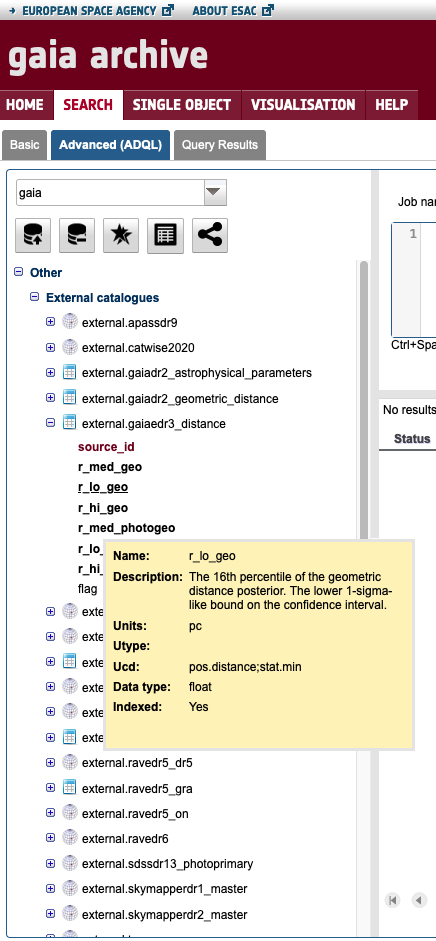

An important part of both data science and astro research is *understanding* the data you are using. <font color='blue'> **(1a)** Using the information at the Gaia webpage, make a new markdown cell where you list each column in the DataFrame, along with a short description of the data contained in the column of interest (be sure to note units in your description!).</font> 

## 1.3 Preliminary Filtering of the Data

Now that we know what the data are, we can remove those rows with missing/Null/NaN/Inf values. In the code cell below, use your knowledge of Pandas functions to list the number of null values for each column. 

After inspecting the number of null values, you will need to produce a mask that selects only the offending rows and removes them. Be sure to check that your code is doing what you think it is (e.g., inspect the length of newly produced data frames and that the final data frame no longer contains nulls).

## 1.4 Selection of Classical Cepheids

During the query of the Gaia archive, we also cross matched to the gaiadr3.vari_cepheid catalogue. This catalogue contains information on Cepheid varible stars including classification of the pulsation mode and the Cepheid type. Use Pandas "groupby" functionality to look at the different classifications. 

<font color='blue'> **(1b)** Filter your catalogue so that it contains only Classical Cepheids (DCEP) observed during their Fundamental pulsation mode. These are the Cepheids that we will use for the remainder of the prac. </font>

## 1.5 Comparing different distance measures

In this Lab, we will need to use the Gaia parallax measurements to determine the distance to our Cepheids in order to determine their absolute magnitudes. There are two main ways to do this. The first is the naive way that we learned in the lectures, i.e., a simple inversion of the parallax in arcseconds gives the distance in parsecs. As we saw in the lectures, this can lead to biased measures of distance when the uncertainty on the parallax is close to its measured value. 

In the query at the beginning, we linked to the external.gaiaedr3_distance catalogue. From this catalogue we have r_med_geo, r_lo_geo, and r_hi_geo measures of the distance and lower and upper confidence estimates to a star (they are the 16th and 84th percentile ranges that represent the 1-\$\sigma$ uncertainty). These values are derived by using Bayesian techniques that use the combination of the parallax measurement and our prior knowledge of how stars are distributed in the Galaxy (see [Bailer-Jones et. al 2018](https://iopscience.iop.org/article/10.3847/1538-3881/aacb21)).

In a new code cell, use the inverse parallax method to determine the distance to each star. Use standard error propagation to determine the error on the distance. Add both of these columns to your dataframe. 

Hint: disregarding correlations between variables, for a function $f(x,y,z...)$ standard error propagation can be determined as:

$$ \sigma_f^2 = \left({\delta f \over \delta x}\right)^2 \sigma_x^2 + \left({\delta f \over \delta y}\right)^2 \sigma_y^2 + \left({\delta f \over \delta z}\right)^2 \sigma_z^2 ...$$ 
Where $\sigma_x$ gives the error on parameter $x$, $\sigma_y$ the uncertainty on $y$ etc.

<font color='blue'>**(1c)** Using a plot, compare the naive estimate of distance to the r_est values. Explain what you see.</font>

Since we will be comparing the results of our Leavitt Law using both the naive and Bailer-Jones distance estimates, you will need to remove rows with non-sensical inverse parallax distance estimates (e.g., negative parallax measurements). 

## 1.6 Determine the *Wesenheit* magnitudes for the Classical Cepheids.

Rather than attempting to determine the individual corrections required to measure luminosities for the Cepheids in the sample, we will be calibrating the so-called *Period-Wesenheit* relation. To do this, we need to first determine the *Wesenheit* magnitude, which provides a first-order correction for the effects of dust reddening in the Gaia G-band (see [here](https://ned.ipac.caltech.edu/level5/Cepheids/Cepheids14.html) for more information). The Wesenheit magnitude is defined in [Ripepi et al. (2019)](https://ui.adsabs.harvard.edu/abs/2019A%26A...625A..14R/abstract) as:

$$ W(G, G_{\rm BP}, G_{\rm RP}) = G - 1.9*(G_{\rm BP}-G_{\rm RP}) $$

where $G, G_{\rm BP}, {\rm and\,} G_{\rm RP}$ are the Gaia magnitudes, and the factor of 1.9 is determined by using Gaia photometry derived from synthetic star templates with effective temperatures and metallicities similar to that expected for Classical Cephieds. This can be used to determine the ratio of extinction ($A_G$) to reddening ($E(G_{\rm BP}-G_{\rm RP})$). 

In the cell below, determine $W( G, G_{\rm BP}, G_{\rm RP})$ for your sample, and also propagate the errors using the errors associated with $G, G_{\rm BP}$, and $G_{\rm RP}$.


<font color='blue'>**(1d)** Using a histogram-style plot, compare the distribution of the $W$ magnitude to the $G, G_{\rm BP}, {\rm and\,} G_{\rm RP}$ bands. Do your $W$ values  make sense?</font>

Now, use both the naive and Bailer-Jones distance estimates to determine the absolute Wesenheit magnitudes, $M_W$. Again, be sure to propagate the uncertainties. Add both columns to your dataframe. <font color='blue'>**(1e)** Compare the two $M_W$ distributions using a histogram plot.</font>

## 1.7 Plotting the $M_W$-Period Relation (PWR).

<font color='blue'>**(1f)** Plot a scatter plot of $log_{10} P$ versus $M_W$ , where $P$ is the period in days for both distance estimates.</font> Be sure to get your y-axis right -- brightness should increase towards the top of the diagram.

<font color='blue'>**(1g)** Describe what you see in the plots. Does it make sense? How does the PWR compare for the two distance estimates?</font>

<font color='blue'>**(1h)** Try filtering your catalogue to include only those objects with ratios of parallax/parallax-error > 5. You can try other values, too. Describe the how changing the parallax-to-parallax-error cut modifies the appearance of the PWR plots. </font>


<font color='blue'>**(1i)** Explore your data -- are the results as expected? Perform any further filtering required to refine the selection and explain why you've made these cuts (hint: generate a scatterplot of the data in Galactic coodinates (l, b) -- you can use different colours to highlight different groupings identified in your PWR).</font>

***
# <font color='red'> You should aim to get to here by the end of the lab in week 3! </font> #
***

# Part 2: Fitting a straight line to the PWR

With our filtered catalogue in hand, we are now in a position to fit the PWR using a straight-line model (i.e., polynomial with order 1). To do this, we will first use standard optimisation, and then we will use MCMC, which explores the parameter space more thoroughly and provides best fit estimates for the parameters and their associated uncertainties.

## 2.1 Setting up for the fitting
To begin, you need to write a function that returns a straight line given a set of parameters, $p$, and an $x$-coordinate. You can look back at the Lectorial notebooks for inspiration!

Be sure to test your function by generating fake x-values and plotting the results for a set of parameters.

Now, define a function that returns the $\chi^2$ for a given set of parameters, $p$, and data points $x, y$ and the uncertainty associated with the $y-$values, $\sigma_y$. We will assume that the uncertainties on the $x-$values are very small, and can therefore be ignored.

## 2.2 Running the fit 
We are now ready to fit the data. Use the fmin function from scipy.optimize to run a simple fit to both PWRs. Don't forget to determine initial estimates for your parameters -- these are required as input to the optimiser. 

Run fits for several different cuts in parallax-to-parallax-error ratios. <font color='blue'>**(2a)** Compare your results using plots and quantitative assessment. One way to quantitatively compare the fidelity of the PWR for the naive and Bailer-Jones distance estimates is to examine the residuals in the $y-$data after subtracting the best-fitting model predicted for the $x-$value. You can plot the histogram of the residuals, which should resemble a Gaussian distribution. You can determine the median and spread (using numpy percentiles, or the mean and standard deviation) for the distribution in order to understand if there is a lower overall scatter for a given distance estimate. How do these values change with changing parallax-to-parallax-error ratios?</font>

<font color='blue'>**(2b)** Choose a sensible value to filter your catalogue that is based on the results for different parallax-to-parallax-error values. </font>

## 2.3 Finalising the best fit parameters

When you plotted the residuals, you may have noticed that there were outliers that were more than $3\sigma$ from the mean/median of the residuals. These outliers can affect the fits. There are several methods by which we can account for these outliers in order to minimise their impact on the fits. Here, we will simply filter those datapoints and refit. 

Using your sample filtered for parallax-to-parallax-error (with your chosen value above), determine which of the objects are outliers (i.e., they are further than $3\sigma$ from the mean/median of the distribution of residuals), and filter those objects out of your sample. Refit both PWRs using your newly cleaned sample. You may wish to repeat this process until all datapoints lie within $\pm 3\sigma$. <font color='blue'> **(2c)** Plot the results of your new fits and compare with the original fit prior to filtering outliers. How do your new fits compare with the original fits?</font>

***
# <font color='red'> You should aim to get to here by the end of the lab in week 4! </font> #
***

## 2.4 Using Markov Chain Monte Carlo (MCMC) sampling to determine best fit parameters and associated uncertainties.

We will now use an MCMC sampler to fit the straight line model to our data. Similar to that seen in lectorial 4, we will use a module called [emcee](https://emcee.readthedocs.io/en/stable/). This is a pure Python implementation of an MCMC sampler that makes many guesses in parallel.

First, you need to import emcee from the Imports folder.

Second, you need to define a function that now returns the log-likelihood, which will be maximised by the emcee sampler. Hint: recall $ln(\mathcal{L}) = -\chi^2/2.$

Once you have this set up, you can follow the procedure outlined in the Lectorial 4 notebook to run the MCMC sample, but modified for the simpler straight-line fit. <font color='blue'> **(2d)** Produce plots that show how your chains evolve, and determine where convergence has occured.</font> Then, rerun your fit now starting at the final position of the first emcee run. <font color='blue'> **(2e)** From this fit, determine the best fit parameters and their uncertainties using the flattened version of the chain for each fitted parameter. How do the MCMC fits compare with the fits determined by scipy.optimize.fmin?</font>

# Part 3: Use your calibrated PWR to determine the distance to the Large Magellanic Cloud (LMC)

Select all delta cepheids in the LMC using a box in galactic coordinates defined by the longitude and latitude range $l=(273, 285)$, $b=(-38, -28)$. Use the best-fitting results from your final calibrated PWR (use the Bailer-Jones PWR), as well as the periods and apparent $W_{G}$ magnitudes to determine the distance to the LMC. 

To do this, you can do the following:
* Use you calibrated PWR to determine the predicted $M_W$ for all Cepheid periods in the LMC, then measure the difference between the predicted value and the apparent $W_{G}$ magnitude. This effectively gives the distance modulus for each Cepheid, from which a sample of distance moduli and, hence, distances can be determined.
* <font color='blue'> **(3a)** Plot up a histogram of the distances determined for the Cephieds in your sample. </font>
* <font color='blue'> **(3b)** From the distribution of distances, determine the median and 68th percentile ranges of the distance to the LMC. How do these values compare with current estimates of the distance to the LMC?</font>
* <font color='blue'> **(3c)** Given your measured distance and the uncertainties on the parallax measurements for Cephieds in the LMC, would it be possible to use Gaia DR3 parallaxes to determine the distance to the LMC?</font>

